In [1]:
import torch
from torch import nn
from torch.nn import functional as F
import pytorch_lightning as pl

In [2]:
import torchaudio

C:\Users\thefo\anaconda3\envs\Algorand\lib\site-packages\torchaudio\extension\extension.py:14: UserWarning: torchaudio C++ extension is not available.
  warnings.warn('torchaudio C++ extension is not available.')
C:\Users\thefo\anaconda3\envs\Algorand\lib\site-packages\torchaudio\backend\utils.py:63: UserWarning: The interface of "soundfile" backend is planned to change in 0.8.0 to match that of "sox_io" backend and the current interface will be removed in 0.9.0. To use the new interface, do `torchaudio.USE_SOUNDFILE_LEGACY_INTERFACE = False` before setting the backend to "soundfile". Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  warnings.warn(


In [3]:
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
torch.cuda.is_available()

True

In [5]:
#Step 1 Loading the data

In [6]:
#Path of the dataset
datapath = Path('Lesson1dataset/ESC-50')

In [7]:
datapath.exists()

True

In [8]:
csv = pd.read_csv(datapath / Path('meta/esc50.csv'))

In [9]:
csv.head()

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


In [10]:
#x, sr = torchaudio.load(datapath / 'audio' / csv.iloc[0,0], normalize=True)
x, sr = torchaudio.load(datapath / 'audio' / csv.iloc[0,0])

In [11]:
x.shape

torch.Size([1, 220500])

In [12]:
#useful to take the audio and reduce the sampling rate
torchaudio.transforms.Resample(orig_freq=sr, new_freq=8000)(x).shape

torch.Size([1, 40000])

In [13]:
h = torchaudio.transforms.MelSpectrogram(sample_rate=sr)(x)

C:\Users\thefo\anaconda3\envs\Algorand\lib\site-packages\torchaudio\functional.py:317: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
C:\Users\thefo\anaconda3\envs\Algorand\lib\site-packages\torch\functional.py:515: UserWarning: stft will require the return_complex parameter be explicitly  specified in a future PyTorch release. Use return_complex=False  to preserve the current behavior or return_complex=True to return  a complex output. (Triggered internally at  ..\aten\src\ATen\native\SpectralOps.cpp:653.)
  return _VF.stft(input, n_fft, hop_length, win_length, window,  # type: ignore
C:\Users\thefo\anaconda3\envs\Algorand\lib\site-packages\torch\functional.py:515: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch

In [14]:
#signal processing, now we have a sort of image (small chunck): width=time height= frequency content
h.shape

torch.Size([1, 128, 1103])

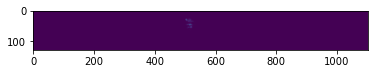

In [15]:
plt.imshow(h[0])

In [16]:
#convert to logarithm, easier to work with NN
h = torchaudio.transforms.AmplitudeToDB()(h)

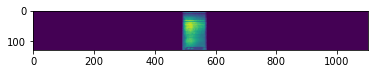

In [17]:
plt.imshow(h[0])

In [18]:
class ESC50Dataset(torch.utils.data.Dataset):
    
    def __init__(self, path: Path = Path('Lesson1dataset/ESC-50'),
                sample_rate:int = 8000,
                folds = [0]): 
        #path=root folder of the dataset (with : you specify type and default value, folds see csv: we are telling which folds we want to import, by default only the first one)
        #Load CSV & Initialize all torchaudio.transforms (standard ops when working with audio)
        #Resample --> MelSpectrogram ->AmplitudeToDB 
        self.path = path
        self.csv = pd.read_csv(path / Path('meta/esc50.csv'))
        self.csv = self.csv[self.csv['fold'].isin(folds)]
        self.resample = torchaudio.transforms.Resample(
            orig_freq=44100, new_freq=sample_rate
        )
        self.melspec=torchaudio.transforms.MelSpectrogram(sample_rate=sample_rate)#n_mels input changes the height of the img
        self.db = torchaudio.transforms.AmplitudeToDB()#top_DB other nice parameter
    
    def __getitem__(self, index): 
        #index using square brackets; like numpy, Pythorch indexes
        #Return (xb, yb) pair (xb is spectogram of the index i, and the second one is the class (an integer))
        row = self.csv.iloc[index]
        wav, _ = torchaudio.load(self.path / 'audio' / row['filename']) #or row.iloc[0]
        label=row['target']
        xb = self.db(
            self.melspec(
                self.resample(wav)
            )
        )
        return xb, label
    
    def __len__(self):
        #tells pytorch how many objects you have in this dataset
        #Returns length
        return len(self.csv)

In [19]:
train_data = ESC50Dataset()

In [20]:
train_data =  ESC50Dataset(folds=[1])
valid_data =  ESC50Dataset(folds=[2])
test_data =  ESC50Dataset(folds=[3])

In [21]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=8, shuffle=True)#small batches without GpU, and shuffling

In [22]:
val_loader = torch.utils.data.DataLoader(valid_data, batch_size=8, shuffle=True)#small batches without GpU, and shuffling

In [23]:
test_loader = torch.utils.data.DataLoader(test_data, batch_size=8, shuffle=True)#small batches without GpU, and shuffling

In [24]:
# part 2 building the model

In [25]:
#1 channel in input, 
class AudioNet(torch.nn.Module):
 
    def __init__(self, n_classes = 50, base_filters = 64):
        super().__init__()
        self.conv1 = nn.Conv2d(1, base_filters, 11, padding=5)
        self.bn1 = nn.BatchNorm2d(base_filters)
        self.conv2 = nn.Conv2d(base_filters, base_filters, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(base_filters)
        self.pool1 = nn.MaxPool2d(2)
        self.conv3 = nn.Conv2d(base_filters, base_filters * 2, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(base_filters * 2)
        self.conv4 = nn.Conv2d(base_filters * 2, base_filters * 4, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(base_filters * 4)
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(base_filters * 4, n_classes)
 
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool1(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool2(x)
        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = self.fc1(x[:, :, 0, 0])
        return x

In [35]:
audionet = AudioNet()

In [27]:
xb,yb = next(iter(train_loader)) # a batch

In [28]:
xb.shape

torch.Size([8, 1, 128, 201])

In [29]:
audionet(xb).shape #for each audio file, a prediction over 50 classes

torch.Size([8, 50])

In [30]:
#pytorch does not have nice high-level utilities:
#I.e., to train the model, write everything step by step (also save checkpoints, conf parameters savings)
#For this reason they started used pytorch lightening library, similar to keras, very simple
#e.g. use LitAutoEncoder and left everything everything to it
#https://pytorch-lightning.readthedocs.io/en/latest/starter/new-project.html#step-1-define-lightningmodule
#to change, simply edit the edit module

In [31]:
#1 channel in input, 
class AudioNet(pl.LightningModule):
 
    def __init__(self, n_classes = 50, base_filters = 64):
        super().__init__()
        self.conv1 = nn.Conv2d(1, base_filters, 11, padding=5)
        self.bn1 = nn.BatchNorm2d(base_filters)
        self.conv2 = nn.Conv2d(base_filters, base_filters, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(base_filters)
        self.pool1 = nn.MaxPool2d(2)
        self.conv3 = nn.Conv2d(base_filters, base_filters * 2, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(base_filters * 2)
        self.conv4 = nn.Conv2d(base_filters * 2, base_filters * 4, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(base_filters * 4)
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(base_filters * 4, n_classes)
 
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool1(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool2(x)
        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = self.fc1(x[:, :, 0, 0])
        return x
    
    
    def training_step(self, batch, batch_idx):
        # training_step defined the train loop.
        # It is independent of forward
        x, y = batch     
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y) #includes a softma self.fc1(x[:, :, 0, 0]) inside for computational reasons
        # Logging to TensorBoard by default
        self.log('train_loss', loss, on_step=True)
        return loss
    
    def validation_step(self, batch, batch_idx): #prima validations steps non c'erano, e credo che il training fini dopo un'epoca
        #for validation (in classification). So, instead of logging loss, we log accuracy
        x,y = batch
        y_hat = self(x)
        #don't put everything into eval or training; it's done automatically
        y_hat = torch.argmax(y_hat, dim=1)#taking predictions and 
        acc = p1.metrics.functional.accuracy(y_hat, y)
        self.log('val_acc', acc, on_epoch=True, progr_bar=True)#log also on the progress bar
        return acc
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [37]:
audionet = AudioNet()

In [38]:
pl.seed_everything(0) #pytorch has this function it sets a seed 0, important

Global seed set to 0


0

In [39]:
trainer=pl.Trainer(gpus=1, max_epochs=1) #which gpus? (it's not tensorflow)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [40]:
trainer.fit(audionet, train_loader, val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name  | Type        | Params
---------------------------------------
0  | conv1 | Conv2d      | 7.8 K 
1  | bn1   | BatchNorm2d | 128   
2  | conv2 | Conv2d      | 36.9 K
3  | bn2   | BatchNorm2d | 128   
4  | pool1 | MaxPool2d   | 0     
5  | conv3 | Conv2d      | 73.9 K
6  | bn3   | BatchNorm2d | 256   
7  | conv4 | Conv2d      | 295 K 
8  | bn4   | BatchNorm2d | 512   
9  | pool2 | MaxPool2d   | 0     
10 | fc1   | Linear      | 12.8 K
---------------------------------------
427 K     Trainable params
0         Non-trainable params
427 K     Total params
1.711     Total estimated model params size (MB)
C:\Users\thefo\anaconda3\envs\Algorand\lib\site-packages\pytorch_lightning\utilities\distributed.py:68: UserWarning: Your val_dataloader has `shuffle=True`, it is best practice to turn this off for validation and test dataloaders.
  warnings.warn(*args, **kwargs)


Validation sanity check: 0it [00:00, ?it/s]

NameError: name 'p1' is not defined

In [ ]:
trainer.eva